# [[ Circuit Generation ]]
We will convert the quantized model in lab1 into system Verilog circuits.

During circuit generation, we can perform some optimization to reduce the circuit size. 
One possibility is that we can find computations shared by different outputs and reuse them.

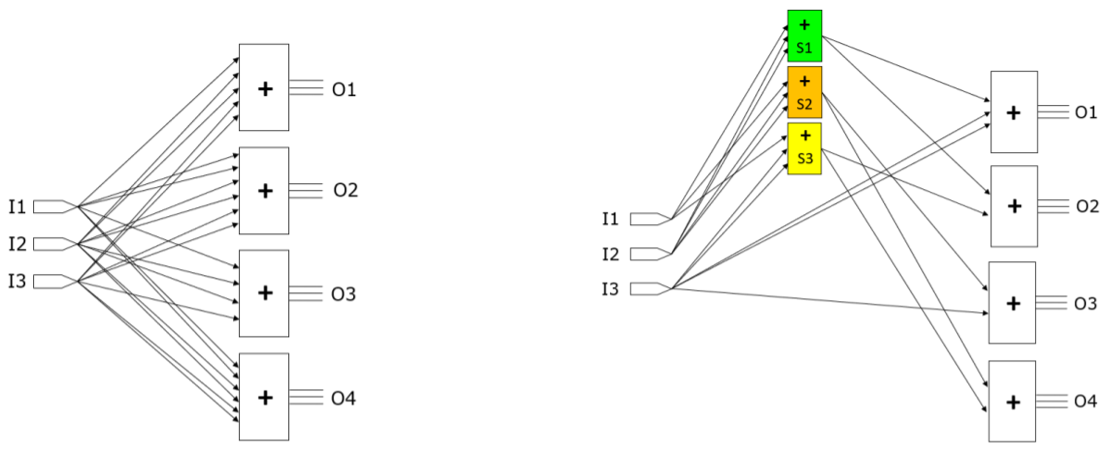

In this lab, we will practice the synthesis flow introduced in the lecture and you are encouraged to design a new algorithm to find sharings.

The flowchart of the synthesis flow is as shown in the following figure:

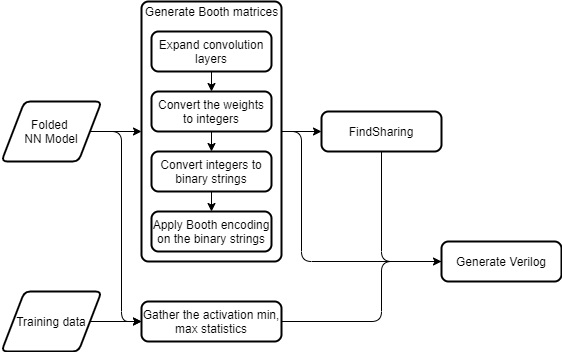

# Get Booth Matrix
We are going to get the Booth matrix of each layer. The procedure includes extract the weight tensor of a layer, convert the weights to integers, use binary encoding to represent the integers and apply Booth encoding on the bit strings.

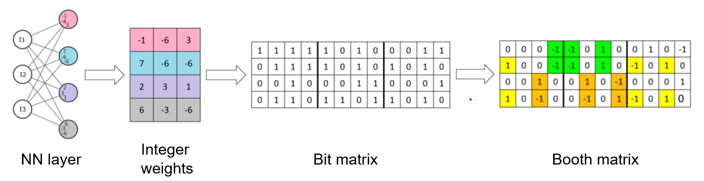

## Convolution layer expansion
The computation of a convolution layer can be converted into the manner of a dense layer.

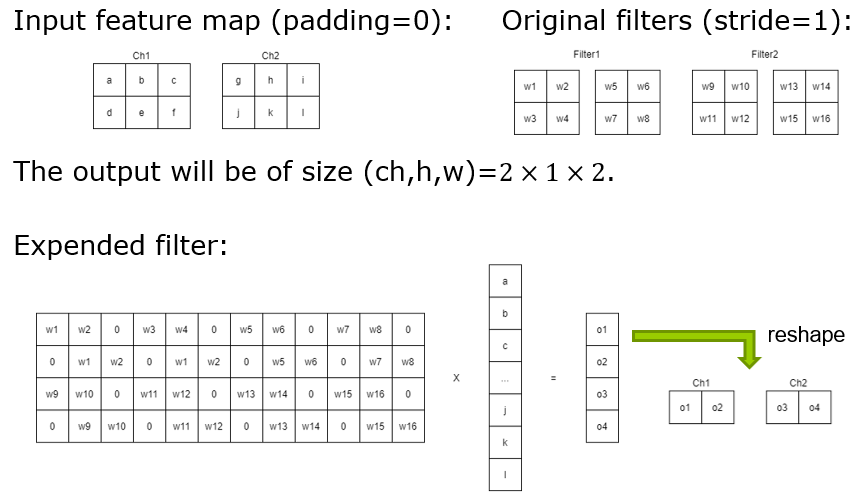


Please finish the function `expandConv`, which does the convolution layer expansion.

Input arguments for `expandConv`:
 - `w`: the weight of a convolution layer
 - `inputSize`: the size of the input feature map of the convolution layer
 - `stride` and `padding`: the stride and padding of the convolution layer

We have computed the size of the resulting matrix and initialize a tensor, `expandedConvW`, of that size whose elements are all zero.
Please fill in `expandedConvW` with correct values. 

In [1]:
import torch
from math import floor

def expandConv(w,inputSize,stride,padding):
    iH,iW = inputSize
    oCh,iCh,kernelSizeH,kernelSizeW = w.size()
    oH = floor((iH+2*padding-kernelSizeH)/stride+1)
    oW = floor((iW+2*padding-kernelSizeW)/stride+1)
    expandedConvW = torch.zeros(oH*oW*oCh,iH*iW*iCh)
    ### TODO Starts ###
    # TODO: Fill in expandedConvW with correct values
    ## Write your code here
    for i in range(oCh):
        for j in range(iCh):
            for k in range(oH):
                for l in range(oW):
                    for m in range(kernelSizeH):
                        for n in range(kernelSizeW):
                            # 忽略 filter 在 padding 的部分
                            if (stride*k+m-padding)>=0 and (stride*k+m-padding)<iH and (stride*l+n-padding)>=0 and (stride*l+n-padding)<iW:
                                expandedConvW [ (oH*oW*i) + (oW*k) + (l) ] [ (iH*iW*j) + (iW*(stride*k-padding)) + (stride*l-padding) + (iW*m) + (n) ] = w[i][j][m][n]
    return expandedConvW

## Get integer weight tensors

The weights of a layer will be first converted to integers with `getFpPos` and `getIntFromQuant`.

In [2]:
def getFpPos(x,numbit=4):
    min_val, max_val = x.min(), x.max()
    print("min:",min_val," max:",max_val)
    fpPos = -torch.ceil(torch.log2((max_val-min_val)/(2.**(numbit)-1.)))
    return fpPos

def getIntFromQuant(x,numbit=4):#convert from fix-point numbers to int
    fp = getFpPos(x,numbit)
    print("fp:",fp)
    return (x*(2**fp)).type(dtype=torch.int8)

## Get Bit matrix
The function `intMat2bitMat` can convert an integer weight tensor into a bit matrix.

In [3]:
def intMat2bitMat(intmat,numbit=4):#convert from int to bit pattern
    posintmat=intmat.clone().type(torch.uint8)
    if len(intmat.size())==2:
        result=torch.zeros([intmat.size()[0],intmat.size()[1]*numbit],dtype=torch.uint8)
        for i in range(posintmat.size()[0]):
            for j in range(posintmat.size()[1]):
                binStr=bin(posintmat[i][j].item()).split('b')[-1].zfill(numbit)[-1*numbit:]
                #print("binStr:",binStr)
                for n,c in enumerate(binStr):
                    result[i][j*numbit+n]=int(c)
    elif len(intmat.size())==1:
        result=torch.zeros(intmat.size()[0]*numbit,dtype=torch.uint8)
        for i in range(posintmat.size()[0]):
            binStr=bin(posintmat[i].item()).split('b')[-1].zfill(numbit)[-1*numbit:]
            for n,c in enumerate(binStr):
                result[i*numbit+n]=int(c)
    return result

## Get Booth matrix
The function  `boothEnc` Booth encodes the bit matrix, and the resulting matrix is the Booth matrix.

In [4]:
def boothEnc(w,numbit=4):#booth encode the bit matrix w, numbit is the bit width
    def boothEncRow(r,numbit=4):
        st,end = None,None
        for i in range(r.size()[0]-1,-1,-1):
            if st==None and r[i]==1 and i!=0:
                st = i
            if st!=None and r[i]==0:
                end = i
                l = st-end
                if l<=2:
                    st,end = None,None
                    continue
                else:
                    r[st] = -1
                    r[end] = 1 if end!=0 else -1
                    r[end+1:st] = torch.zeros(l-1)
                    st,end = None,None
                    continue
            if st!=None and i==0 and r[i]==1:
                r[st] = -1
                r[0:st] = torch.zeros(st)
        r[0]*=-1
    
    rst = w.clone().type(torch.int)
    for run in range(1):
        if len(rst.size())==2: # 2 dimensional matrix
            for r in rst:
                for i in range(0,r.size()[0],numbit):
                    boothEncRow(r[i:i+numbit],numbit)
        elif len(rst.size())==1: # 1 dimensional matrix
            for i in range(0,rst.size()[0],numbit):
                boothEncRow(rst[i:i+numbit],numbit)
    return rst 

We will also generate versoins of circuits without Booth encoding.
To do so, we use the bit matrices for later steps (find sharing and circuit generation).
However, to make other codes work properly, we have to make the sign bit of each binary number in the bit matrice -1 if it is 1.
The following `toTernary` function does this for us.
The resulting ternary matrices will be named `*wBitTer.pt` where `*` is the layer name.
Replace `*wBitBoo.pt` to `*wBitTer.pt` in later steps for circuit versions without Booth encoding.

In [5]:
def toTernary(w,numbit=4):#convert the MSB of each binary number to -1 if it is negative
    def negMSB(r):
        r[0]*=-1
    
    rst = w.clone().type(torch.int)
    if len(rst.size())==2: # 2 dimensional matrix
        for r in rst:
            for i in range(0,r.size()[0],numbit):
                negMSB(r[i:i+numbit])
    elif len(rst.size())==1: # 1 dimensional matrix
        for i in range(0,rst.size()[0],numbit):
            negMSB(rst[i:i+numbit])
    return rst 

Go through the procedures of getting Booth matrix will the above functions

Note that you may have to modify the paths in the following code block. 
If your model architecture is different, you may also have to modify the code to match your model.

In [6]:
# ==================================================
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple
QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])
def quantize_tensor(x, num_bits=8, min_val=None, max_val=None,imposePow=None,roundType='round'):
    if imposePow is not None:
        scale=2**(-1*imposePow)
    else:
        if not min_val and not max_val: 
            min_val, max_val = x.min(), x.max()
        if min_val!=max_val:
            scale=2**(torch.ceil(torch.log2((max_val-min_val)/(2.**(num_bits)-1.))))
        else:
            scale=2**(torch.ceil(torch.log2((torch.tensor([1e-4]))/(2.**(num_bits)-1.))))
    zero_point=0
    q_x = zero_point + x / scale
    qmin = (2.**(num_bits-1))*(-1.)
    qmax = 2.**(num_bits-1) - 1.
    if roundType=='round':
        q_x.clamp_(qmin, qmax).round_()
    elif roundType=='floor':
        q_x.clamp_(qmin, qmax).floor_()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

class FakeQuantOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, w, numBits=4,imposePow=None,roundType='round'):
        x = quantize_tensor(w,num_bits=numBits,imposePow=imposePow,roundType=roundType)
        x = dequantize_tensor(x)
        return x
    @staticmethod
    def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None, None, None

class ModelMnist_quant(nn.Module):
    def __init__(self,numNeurons=32,nBits=4):
        super(ModelMnist_quant, self).__init__()

        self.numNeurons = numNeurons
        self.nBits = nBits

        self.conv1 = ConvBN_Quant(1,3,3,stride=2,padding=0,nBits=nBits)#output 3*13*13
        self.fc1 = Linear_Quant(3*13*13, 32,nBits=nBits)
        self.fc2 = Linear_Quant(32,32,nBits=nBits)
        self.fc3 = Linear_Quant(32,10,nBits=nBits)
        self.dropout=nn.Dropout(p=0.35)
      
    def forward(self, x):
        x = self.conv1(x)
        x=F.relu6(x)
        x=FakeQuantOp.apply(x,self.nBits,self.nBits-4,'floor')

        x=x.view(-1,3*13*13)
        x=self.dropout(x)
        x=self.fc1(x)
        x=F.relu6(x)
        s=self.dropout(x)
        x=FakeQuantOp.apply(x,self.nBits,self.nBits-4,'floor')
        
        x=self.fc2(x)
        x=F.relu6(x)
        x=FakeQuantOp.apply(x,self.nBits,self.nBits-4,'floor')
        
        x=self.fc3(x)
        x=FakeQuantOp.apply(x,self.nBits,self.nBits-4,'floor')
        
        return x

    def foldAndQuantize(self):
        self.conv1.foldAndQuantize()
        self.fc1.quantize()
        self.fc2.quantize()
        self.fc3.quantize()

class ConvBN_Quant(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, padding=1,nBits=8):
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.nBits=nBits
        super(ConvBN_Quant, self).__init__()
        self.conv = nn.Conv2d(in_planes,out_planes,kernel_size,stride,padding)
        self.bn = nn.BatchNorm2d(out_planes)
        self.folded = False
        self.quantized = False

    def forward(self,x):
        r=self.bn.weight.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        var=self.bn.running_var.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        
        if not self.folded:
            w=self.conv.weight*r/(torch.sqrt(var+self.bn.eps))
            b=(self.conv.bias-self.bn.running_mean)*self.bn.weight/(torch.sqrt(self.bn.running_var+self.bn.eps))+self.bn.bias
        else:
            w=self.conv.weight
            b=self.conv.bias
        if not self.quantized:        
            w=FakeQuantOp.apply(w,self.nBits)
            b=FakeQuantOp.apply(b,self.nBits)

        x=F.conv2d(x,w,b,self.stride,self.padding)
        return x

    def fold(self):
        r=self.bn.weight.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        var=self.bn.running_var.unsqueeze(1).unsqueeze(1).unsqueeze(1)
        self.conv.weight.data = self.conv.weight.data*r/(torch.sqrt(var+self.bn.eps))
        self.conv.bias.data = (self.conv.bias.data-self.bn.running_mean)*self.bn.weight.data/(torch.sqrt(self.bn.running_var+self.bn.eps))+self.bn.bias.data
        self.folded = True

    def foldAndQuantize(self):
        self.fold()
        self.quantized = True
        self.conv.weight.data = FakeQuantOp.apply(self.conv.weight.data,self.nBits)
        self.conv.bias.data = FakeQuantOp.apply(self.conv.bias.data,self.nBits)

class Linear_Quant(nn.Module):
    def __init__(self,in_features,out_features,nBits=8):
        super(Linear_Quant,self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.nBits = nBits
        self.fc = nn.Linear(in_features,out_features)
        self.quantized = False

    def forward(self,x):
        w = self.fc.weight
        b = self.fc.bias
        if not self.quantized:
            w = FakeQuantOp.apply(w,self.nBits)
            b = FakeQuantOp.apply(b,self.nBits)
        x=F.linear(x,w,b)
        return x

    def quantize(self):
        self.quantized = True
        self.fc.weight.data = FakeQuantOp.apply(self.fc.weight.data,self.nBits)
        self.fc.bias.data = FakeQuantOp.apply(self.fc.bias.data,self.nBits)
# ==================================================

In [ ]:
#modelPath = "/content/drive/MyDrive/EDA_project/model/mnistModel_quant.pt" #modify to your model path
modelPath = "model.pt"
model = torch.load(modelPath,map_location=torch.device('cuda'))
model.eval()
model.foldAndQuantize()
weights=[]
fileNames=['conv1w','conv1b','fc1w','fc1b','fc2w','fc2b','fc3w','fc3b']
conv1w=model.conv1.conv.weight
conv1w=expandConv(conv1w,(28,28),2,0) # remember change stride
conv1wInt=getIntFromQuant(conv1w)
weights.append(conv1wInt)
conv1b=model.conv1.conv.bias
conv1bInt=getIntFromQuant(conv1b)
weights.append(conv1bInt)

fc1w=model.fc1.fc.weight
fc1wInt=getIntFromQuant(fc1w)
weights.append(fc1wInt)
fc1b=model.fc1.fc.bias
fc1bInt=getIntFromQuant(fc1b)
weights.append(fc1bInt)
fc2w=model.fc2.fc.weight
fc2wInt=getIntFromQuant(fc2w)
weights.append(fc2wInt)
fc2b=model.fc2.fc.bias
fc2bInt=getIntFromQuant(fc2b)
weights.append(fc2bInt)
fc3w=model.fc3.fc.weight
fc3wInt=getIntFromQuant(fc3w)
weights.append(fc3wInt)
fc3b=model.fc3.fc.bias
fc3bInt=getIntFromQuant(fc3b)
weights.append(fc3bInt)

!mkdir -p weights # create the "weights" floder in the file system of colab
savingPath="./weights/" #modify to your saving path
for i,w in enumerate(weights):
    print("processing layer: ",fileNames[i])
    print("\tconverting to bit matrix...")
    wBit=intMat2bitMat(w)
    print("\tconverting to ternary matrix...")
    wTernary=toTernary(wBit)
    print("\tconverting to Booth matrix...")
    wBitBooth=boothEnc(wBit)
    torch.save(w,savingPath+fileNames[i]+'.pt')
    torch.save(wBit,savingPath+fileNames[i]+'Bit.pt')
    torch.save(wTernary,savingPath+fileNames[i]+'BitTer.pt')
    torch.save(wBitBooth,savingPath+fileNames[i]+'BitBoo.pt')


# Find Sharing

After the Booth matrices are obtained, we are going to find shared computation in the Booth matrices.
You can reimplement the introduced algorithm in the lecture or design and implement your own algorithm.

To make sure the found sharings can be used in other codes, please represent each sharing as an instance of the following `Sharing` class.
The `Sharing` class has three members: `c_setPos`, `c_setNeg` and `r_set`. 
- The `r_set` is a python set contains the row indices of the sharing.
- The `c_setPos` is a python set contains the column indices of the elements that are 1 in the sharing.
- The `c_setNeg` is a python set contains the column indices of the elements that are -1 in the sharing.

**Note that since two rows in a sharing can have a different sign, for `c_setPos` and `c_setNeg`, you have to detemine the sign with a particular row.**

Here is an example of representing a sharing with `Sharing`:

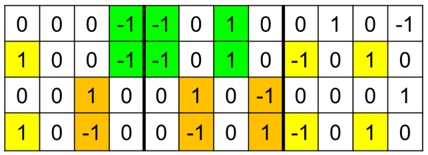

- Green sharing: `r_set`={0,1}, `c_setPos`={6}, `c_setNeg`={3,4}
- Orange sharing: `r_set`={2,3}, `c_setPos`={2,5}, `c_setNeg`={7}
- Yellow sharing: `r_set`={1,3}, `c_setPos`={0,10}, `c_setNeg`={8}

In [ ]:
import networkx as nx

class Sharing():
    # Note:
    # Each instance of Sharing corresponds to a sharing in the course.
    # The member r_set should be a set (the set type in python), and it contains the row indices for this sharing. 
    # The member c_setPos should be a set (the set type in python), and it contains the column indices of positive elements in this sharing.
    # The member c_setNeg should be a set (the set type in python), and it contains the column indices of negative elements in this sharing.
    # Note that since two rows in a sharing can have different sign, for c_setPos and c_setNeg, you have to detemine the sign with a same row.
    def __init__(self, W, pair):
        self.r_set, self.c_setPos, self.c_setNeg = self.set_generation(W, pair)

    def set_generation(self, W, pair):

        r_set = pair[0]
        c_setPos = set()
        c_setNeg = set()

        for i in range(len(pair[1])):
            if (W[list(pair[0])[0]][list(pair[1])[i]] == 1):
                c_setPos.add(list(pair[1])[i])
            else :
                c_setNeg.add(list(pair[1])[i])
        
        return r_set, c_setPos, c_setNeg

    # ==========

# Find-Max-Pairing
def PairRows(unsharedCol, pair):
    S_same = [pair, set()]
    S_diff = [pair, set()]
    for k in range(unsharedCol.shape[1]):
        row1 = unsharedCol[list(pair)[0]][k]
        row2 = unsharedCol[list(pair)[1]][k]

        if (row1 * row2 == 1):
            S_same[1].add(k)
        elif (row1 * row2 == -1):
            S_diff[1].add(k)

    return S_same, S_diff

def Gain(S):
    row = len(S[0])
    col = len(S[1])
    return row * col - (row + col)

def ConstructGraph(W, unsharedCol):
    G = nx.Graph()
    for i in range(W.shape[0]-1):
        for j in range(i+1, W.shape[0]):
            if (torch.mul(unsharedCol[i], unsharedCol[j]).any()):
                S_same, S_diff = PairRows(unsharedCol, set((i,j)))
                weight = Gain(S_same) + Gain(S_diff)
                G.add_weighted_edges_from([(i,j,weight)])
    
    return G

def FindMaxPairing(W, unsharedCol):
    graph = ConstructGraph(W, unsharedCol)
    pairs = sorted(nx.max_weight_matching(graph))
    result = []
    for i in range(len(pairs)):
        S_same, S_diff = PairRows(unsharedCol, pairs[i])
        if (Gain(S_same) > 0):
            result.append(S_same)
        if (Gain(S_diff) > 0):
            result.append(S_diff)

    return result

def refine(unsharedCol, shares):
    for i in range(len(shares)):
        for j in range(len(shares[i][0])):
            for k in range(len(shares[i][1])):
                unsharedCol[list(shares[i][0])[j]][list(shares[i][1])[k]] = 0

    return unsharedCol

def FindSharing(W):
    result = []
    unsharedCol = W
    sharings = FindMaxPairing(W, unsharedCol)
    while(len(sharings) > 0):
        result.extend(sharings)
        unsharedCol = refine(unsharedCol, sharings)
        sharings = FindMaxPairing(W, unsharedCol)
    
    return result


Implement the algorithm for finding sharings in the following code block.

Please put each the instance of each sharing into the list `resultSharings`.

The python dictionary, `rstUnSharedW` is a mapping from a row index to a set containing the column indices of non-zero entries in that row.

Take the following sharing result as example,

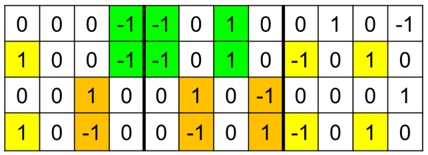

`rstUnSharedW` will be {0:{9,11}, 1:{}, 2:{11}, 3:{}}.

Please set `rstUnSharedW` based on the sharing you found.

You may have to modify `layers` if your model architecture is different.

In [ ]:
import pickle
import copy

### TODO Starts ### 
# TODO: You may have to modify the following line to match your model.
layers=["conv1","fc1","fc2","fc3"]

!mkdir sharings

### TODO Ends ### 
for lind,layer in enumerate(layers):
    ### TODO Starts ### 
    # TODO: Implement code to find sharing
    # Basically, you have to set the values of resultSharings and rstUnSharedW.
    # resultSharings: A list of sharings you found.
    # rstUnSharedW: It is a dictionary that maps each row index to a set. Each set contains the column indices that are not used in any sharing and the corresponding value is not 0.
    # Use *wBitBoo for the version with Booth encoding and use *wBitTer for the version without Booth encoding, where * is the layer name.
    ## Write you code here

    weightPath = f"./weights/{layer}wBitBoo.pt"
    W = torch.load(weightPath,map_location=torch.device('cpu'))

    resultSharings = []
    ori_W = copy.deepcopy(W)   # W will change after 'FindSharing(W)' !!!
    
    result = FindSharing(W)
    # =====
    #result = []
    # =====

    for i in range(len(result)):
        temp = Sharing(ori_W, result[i])    # use ori_W here
        resultSharings.append(temp)

    rstUnSharedW=dict()

    for i in range(W.shape[0]):
        temp = set()
        rstUnSharedW[i] = temp
        for j in range(W.shape[1]):
            if (W[i][j] != 0):
                rstUnSharedW[i].add(j)

    print(layer)
    print("total shared pairs : ", len(resultSharings))
    cal_num_pos = 0
    cal_num_neg = 0
    for i in range(len(resultSharings)):
        cal_num_pos += len(resultSharings[i].c_setPos)
        cal_num_neg += len(resultSharings[i].c_setNeg)
    print("total shared pos col : ", cal_num_pos)
    print("total shared neg col : ", cal_num_neg)

    total_left = 0
    for i in range(len(rstUnSharedW)):
        print(f"row{i} left : ", len(rstUnSharedW[i]))
        total_left += len(rstUnSharedW[i])
    print("total left : ", total_left)
    print("========================================")


    pickle.dump(resultSharings,open(f"./sharings/{layer}SharedW.pkl",'wb')) # change sharings to sharings_noBooth for the version without Booth encoding
    pickle.dump(rstUnSharedW,open(f"./sharings/{layer}UnsharedW.pkl",'wb')) # change sharings to sharings_noBooth for the version without Booth encoding
    ### TODO Ends ### 

We will also generate versions of circuits without sharing so that we can know how much hardware resources our sharing algorithm reduces. 
To do so, we can simply generate an empty sharing list and record all non-zero entries in `rstUnSharedW`, which are as shown in the following code block.
Note that you may have to modify `layers` to match your model architecture and the paths. 
The generated “empty sharings” can be used later to generate circuits without sharing.
Note that for the version without Booth encoding, you have to run this code block again with `*wBitTer`.

In [ ]:
### TODO Starts ### 
# TODO: You may have to modify the following line to match your model.
layers=["conv1","fc1","fc2","fc3"]
### TODO Ends ### 
!mkdir emptySharings # create the emptySharings folder in the file system of colab

for lind,layer in enumerate(layers):
    resultSharings = []
    rstUnSharedW=dict()
    w = torch.load(f"/content/weights/{layer}wBitBoo.pt")
    for rowInd,row in enumerate(w):
        s = set()
        for colInd,col in enumerate(row):
            if col!=0:
                s.add(colInd)
        rstUnSharedW[rowInd] = s 
    
    pickle.dump(resultSharings,open(f"./emptySharings/{layer}SharedW.pkl",'wb'))
    pickle.dump(rstUnSharedW,open(f"./emptySharings/{layer}UnsharedW.pkl",'wb'))

# Gather Activation Statistics
When implementing the circuit, we have to know how many bits we need to use for the imtermediate results.
In the following code blocks, we run through the images in the training set and record such information.
The results will be dumped into `actStats.pkl`.

Helper functions

In [ ]:
from torchvision import datasets, transforms
from torchvision.transforms.transforms import RandomRotation

def getDataLoader(batch_size = 256):
    dataset_all = datasets.MNIST('../1_modelTraining/data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                          #  =====
                           #transforms.RandomRotation(5),
                          #  =====
                           transforms.Normalize((0.5,), (0.5,))
                       ]))
    train_set, val_set = torch.utils.data.random_split(dataset_all, [50000, 10000])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=batch_size, shuffle=False)
    return train_loader,valid_loader,test_loader

def getDataLoader_trainOnly(batch_size = 256):
    dataset_all = datasets.MNIST('../1_modelTraining/data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ]))
    train_loader = torch.utils.data.DataLoader(dataset_all, batch_size=batch_size, shuffle=True)
    return train_loader

def getFpPos(min_val,max_val,numbit=4):
    fpPos = -torch.ceil(torch.log2((max_val-min_val)/(2.**(numbit)-1.)))
    return fpPos

from collections import namedtuple

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def quantize_tensor(x, num_bits=8, min_val=None, max_val=None,imposePow=None,roundType='round'):
    if imposePow is not None:
        scale=2**(-1*imposePow)
    else:
        if not min_val and not max_val: 
            min_val, max_val = x.min(), x.max()
        if min_val!=max_val:
            scale=2**(torch.ceil(torch.log2((max_val-min_val)/(2.**(num_bits)-1.))))
        else:
            scale=2**(torch.ceil(torch.log2((torch.tensor([1e-4]))/(2.**(num_bits)-1.))))
    zero_point=0
    q_x = zero_point + x / scale
    qmin = (2.**(num_bits-1))*(-1.)
    qmax = 2.**(num_bits-1) - 1.
    if roundType=='round':
        q_x.clamp_(qmin, qmax).round_()
    elif roundType=='floor':
        q_x.clamp_(qmin, qmax).floor_()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

class FakeQuantOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, w, numBits=4,imposePow=None,roundType='round'):
        x = quantize_tensor(w,num_bits=numBits,imposePow=imposePow,roundType=roundType)
        x = dequantize_tensor(x)
        return x
    @staticmethod
    def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None, None, None

You may have to modify the path in the following code blocks.
If your model architecture is different, please modif the following code accordingly.

In [ ]:
import torch.nn.functional as F
from math import floor

model=torch.load("model.pt",map_location=torch.device('cpu'))
model.eval()
model.foldAndQuantize()

stats = dict()
stats['conv1w']=[model.conv1.conv.weight.min(),model.conv1.conv.weight.max()]
stats['conv1b']=[model.conv1.conv.bias.min(),model.conv1.conv.bias.max()]
stats['fc1w']=[model.fc1.fc.weight.min(),model.fc1.fc.weight.max()]
stats['fc1b']=[model.fc1.fc.bias.min(),model.fc1.fc.bias.max()]
stats['fc2w']=[model.fc2.fc.weight.min(),model.fc2.fc.weight.max()]
stats['fc2b']=[model.fc2.fc.bias.min(),model.fc2.fc.bias.max()]
stats['fc3w']=[model.fc3.fc.weight.min(),model.fc3.fc.weight.max()]
stats['fc3b']=[model.fc3.fc.bias.min(),model.fc3.fc.bias.max()]

train_loader = getDataLoader_trainOnly(256)
nBits = 4
stats['input'] = [float('inf'),float('-inf')]
stats['conv1Act'] = [float('inf'),float('-inf')]
stats['fc1Act'] = [float('inf'),float('-inf')]
stats['fc2Act'] = [float('inf'),float('-inf')]
stats['fc3Act'] = [float('inf'),float('-inf')]
correctCount=0
for x,y in train_loader:
    stats['input'][0]=min(stats['input'][0],x.min())
    stats['input'][1]=max(stats['input'][1],x.max())
    x=torch.clamp(torch.round(x*64.0),-128.0,127.0)/64.0

    x=model.conv1.conv(x)
    stats['conv1Act'][0]=min(stats['conv1Act'][0],x.min())
    stats['conv1Act'][1]=max(stats['conv1Act'][1],x.max())
    x=F.relu6(x)
    x=FakeQuantOp.apply(x,nBits,0,'floor')

    x=x.view(x.size()[0],-1)
    x=model.fc1(x)
    stats['fc1Act'][0]=min(stats['fc1Act'][0],x.min())
    stats['fc1Act'][1]=max(stats['fc1Act'][1],x.max())
    x=F.relu6(x)
    x=FakeQuantOp.apply(x,nBits,0,'floor')

    x=model.fc2(x)
    stats['fc2Act'][0]=min(stats['fc2Act'][0],x.min())
    stats['fc2Act'][1]=max(stats['fc2Act'][1],x.max())
    x=F.relu6(x)
    x=FakeQuantOp.apply(x,nBits,0,'floor')  

    x=model.fc3(x)
    stats['fc3Act'][0]=min(stats['fc3Act'][0],x.min())
    stats['fc3Act'][1]=max(stats['fc3Act'][1],x.max())
    x=FakeQuantOp.apply(x,nBits,0,'floor') 

    pred=x.max(1)[1]
    correctCount+=torch.sum(pred==y).item()

for k in stats:
    v=stats[k]
    if "Act" in k:
        # For activations, record the number of bits needed for the integer part
        v.append(nBits-getFpPos(v[0],v[1],nBits).item())
    else:
        # For weights and biases, record the number of bits for the fraction part
        v.append(getFpPos(v[0],v[1],nBits).item())

with open("actStats.pkl",'wb') as f:
    pickle.dump(stats,f)

# Generate Circuits
With all the previous steps finished, we can start to generate the system Verilog circuits.

The `genModel` function will generate the module for the model.
The `genLayer` function will generate the module for a layer. 
All the TODOs are in the `genLayer` function.
Please follow the description of each TODO to finish this function.

We offered two example Verilog files for reference. 
One of them is a non-input layer (fc2.sv) and the other one is the output layer (fc3.sv).

You may have to modify `modelName`, `layers` and `layerNBits` to match your model.




In [ ]:
## AIG version
import math

modleName = "model" # it will be the module name for the whole model
nBitsImage = 8 #  bitwidth for input images
nBitsInt_img = 2
layers = ['conv1','fc1','fc2','fc3'] # the name of each layer, it will be the module name for that layer
inputLayerName = layers[0]
outputLayerName = layers[-1]
layerNBits = {'conv1':4,'fc1':4,'fc2':4,'fc3':4}

! mkdir circuits_layerPipe

def genModel(moduleName,layers,outputSizes,layerNBits):
    file = open("circuits_layerPipe/"+moduleName+'.v','w')
    file.write(f"module {moduleName}(\n")
    file.write(f"\tinput [{int(nBitsImage*784-1)}:0] data,\n")
    file.write("\toutput [9:0] out\n);\n\n")
    for i,layer in enumerate(layers):
        if i==0:
            file.write(f"wire [{int(nBitsImage*784-1)}:0] {layer}_in;\n")
        if i>0:
            file.write(f"wire [{int(layerNBits[layer]*outputSizes[i-1]-1)}:0] {layer}_in;\n")
        if i<len(layers)-1:
            file.write(f"wire [{layerNBits[layer]*outputSizes[i]-1}:0] {layer}_out;\n")
    file.write("\n")
    file.write("genvar idx;\n")
    file.write("generate\n")
    file.write("\tfor (idx=1; idx<=784; idx=idx+1) begin\n")
    file.write("\t\tassign conv1_in[(8*idx-1)-:8] = $signed({1'b0,data[(8*idx-1)-:7]})-$signed(8'd64);\n")
    file.write("\tend\n")
    file.write("endgenerate\n")
    file.write("\n")
    for i,layer in enumerate(layers):
        if i==len(layers)-1:
            file.write(f"{layer} {layer}_inst(.in({layer}_in),.out(out));\n")
        else:
            file.write(f"{layer} {layer}_inst(.in({layer}_in),.out({layer}_out));\n")
    file.write("\n")
    for i in range(1,len(layers)):
        file.write(f"assign {layers[i]}_in = {layers[i-1]}_out;\n")
    file.write("\nendmodule\n")
    file.close()

def genLayer(moduleName,weight,bias,sharedWs,unsharedWs,fpPos_w,fpPos_b,nBits,nBitsInt_out):
    # fpPos_w      : the number of bits for the fractional fractional part of the weight
    # fpPos_b      : the number of bits for the fractional fractional part of the bias
    # nBitsInt_out : the number of bits for the integer part of the weighted sum
    # The above three numbers will be computeded in getActStats.py and stored in actStats.pkl

    file = open("circuits_layerPipe/"+moduleName+'.v','w')
    # Compute needed information
    isInputLayer = moduleName==inputLayerName
    isOutputLayer = moduleName==outputLayerName
    nBitsInput = nBitsImage if isInputLayer else nBits # bitwidth of the input of this layer
    nInput = weight.size()[1]/nBits # number of inputs
    nOutput = weight.size()[0] # number of outputs
    nBitsFrac_out = int(fpPos_w + (nBitsImage-nBitsInt_img if isInputLayer else 0))
    nBits_out = int(nBitsInt_out + nBitsFrac_out)
    print("\tfpPos_w:",fpPos_w)
    print("\tfpPos_b:",fpPos_b)
    print("\tnBitsInt_out:",int(nBitsInt_out))
    print("\tnBitsFrac_out:",nBitsFrac_out)
    print("\tnBits_out:",nBits_out)
    print("===")
    ### TODO Starts ### 
    # TODO1: Generate the module and port
    # Example:
    # module conv1 (
    #     input [7:0] in [0:783],
    #     input clk,
    #     input rst,
    #     output [3:0] out [0:506]
    # );
    ## Write your code here (in this TODO, write to file)
    if (not isOutputLayer):
        file.write(f"module {moduleName} (\n")
        file.write(f"\tinput [{int(nBitsInput*nInput-1)}:0] in,\n")
        file.write(f"\toutput [{int(nBits*nOutput-1)}:0] out\n")       
        file.write(");\n\n")

    else:
        file.write(f"module {moduleName} (\n")
        file.write(f"\tinput [{int(nBitsInput*nInput-1)}:0] in,\n")
        file.write("\toutput [9:0] out\n")
        file.write(");\n\n")

    # TODO2: Declare wires or registers for weighted_sum and sharings
    # Example:
    # logic [12:0] weighted_sum [0:506];
    # logic [12:0] sharing0_r, sharing0_w;
    # logic [12:0] sharing1_r, sharing1_w;
    # logic [12:0] sharing2_r, sharing2_w;
    # ...
    ## Write your code here (in this TODO, write to file)

    # if isInputLayer or isOutputLayer:
    #     file.write(f"wire [{nBits_out}:0] weighted_sum [0:{nOutput-1}];\n")
    # else:
    if not isOutputLayer:
        file.write(f"wire [{nBits-1}:0] relu_out [0:{nOutput-1}];\n")
    file.write(f"wire [{nBits_out-1}:0] weighted_sum [0:{nOutput-1}];\n")
    for i in range(len(sharedWs)):
        file.write(f"wire [{nBits_out-1}:0] sharing{i};\n")
    file.write("\n")

    # TODO3: Write computation of sharings
    # The computation will be put in the always block (between "always_comb begin" and "end")
    # Example:
    # always_comb begin
    #     sharing0_w = $signed({in[604],1'b0})+$signed(in[576])+$signed(-{in[634],1'b0});
    #     sharing1_w = $signed({in[374],1'b0})+$signed(in[346])+$signed(-{in[404],1'b0});
    #     sharing2_w = $signed(-{in[684],1'b0})+$signed({in[654],1'b0})+$signed(in[626]);
    # ...
    # end
    ## Write your code here (in this TODO, write to file)
    for i in range(len(sharedWs)):
        file.write(f"assign sharing{i} = ")
        temp_term = ""
        for j in sharedWs[i].c_setPos:  
            temp_term += "$signed("
            if (j%nBits == nBits-1):
                temp_term += f"in[{int(j/nBits+1)*int(nBitsInput)-1}-:{int(nBitsInput)}])+"
            else:
                temp_term += "{"
                temp_term += f"in[{int(j/nBits+1)*int(nBitsInput)-1}-:{int(nBitsInput)}]"
                temp_term += f",{nBits-1-(j%nBits)}"
                temp_term += "'b0})+"

        for j in sharedWs[i].c_setNeg:
            temp_term += "$signed("
            if (j%nBits == nBits-1):
                temp_term += f"-in[{int(j/nBits+1)*int(nBitsInput)-1}-:{int(nBitsInput)}])+"
            else:
                temp_term += "-{"
                temp_term += f"in[{int(j/nBits+1)*int(nBitsInput)-1}-:{int(nBitsInput)}]"
                temp_term += f",{nBits-1-(j%nBits)}"
                temp_term += "'b0})+"

        temp_term = temp_term[:-1]
        temp_term += ";"

        file.write(temp_term)
        file.write('\n')

    # TODO4: Write computation of weighted sum
    # Example:
    # assign weighted_sum[0] = $signed({in[0],2'b0})+$signed({in[56],1'b0})+$signed({in[56],2'b0})+$signed(-{in[1],1'b0})+$signed(-in[57])+$signed(-{in[2],3'b0})+$signed({in[2],1'b0})+$signed(in[2])+$signed({in[28],2'b0})+$signed(-{in[29],1'b0})+$signed(-{in[30],2'b0})+$signed(sharing47_r)+$signed(-128);
    # assign weighted_sum[1] = $signed(-{in[32],2'b0})+$signed({in[58],2'b0})+$signed({in[58],1'b0})+$signed({in[2],2'b0})+$signed(-{in[3],1'b0})+$signed(-in[59])+$signed(-{in[4],3'b0})+$signed({in[4],1'b0})+$signed(in[4])+$signed({in[30],2'b0})+$signed(-{in[31],1'b0})+$signed(sharing51_r)+$signed(-128);
    # assign weighted_sum[2] = $signed({in[32],2'b0})+$signed(-{in[33],1'b0})+$signed(-{in[34],2'b0})+$signed({in[60],2'b0})+$signed({in[60],1'b0})+$signed({in[4],2'b0})+$signed(-{in[5],1'b0})+$signed(-in[61])+$signed(-{in[6],3'b0})+$signed({in[6],1'b0})+$signed(in[6])+$signed(sharing68_r)+$signed(-128);
    # ...
    # To do so, we have to first gather information about the sharings used by each output.
    # This is done for you in the following codes.
    # The results are stored in the dict sharingMap, where the key is the row index and the value is a list of strings containing strings like "$signed(-sharing{0}_r)".
    # In TODO4.1, you have to collect other additive terms regarding the inputs (e.g., "$signed({in[685],1'b0})")
    # In TODO4.2, you have to add the bias after correctly shifted into the additive terms derived in TODO4.1
    # The remaining part of codes will use the join function of string in python to write the Verilog code

    # Gather sharing information
    sharingMap=dict()
    for i,sh in enumerate(sharedWs):
        egWInd=list(sh.c_setPos|sh.c_setNeg)[0]
        r0=list(sh.r_set)[0]
        for r in sh.r_set:
            if r in sharingMap:
                if weight[r][egWInd]==weight[r0][egWInd]:
                    sharingMap[r].append(f"$signed(sharing{i})")
                else:
                    sharingMap[r].append(f"$signed(-sharing{i})")
            else:
                if weight[r][egWInd]==weight[r0][egWInd]:
                    sharingMap[r]=[f"$signed(sharing{i})"]
                else:
                    sharingMap[r]=[f"$signed(-sharing{i})"]
    for outInd in range(nOutput):
        terms = []
        row = weight[outInd]
        if outInd not in unsharedWs:
            pass
        for col in unsharedWs[outInd]: # for each elements in W_B not in any sharing
            weightInd = col//nBits
            bit_ind=nBits-1-(col%nBits)#from LSB to MSB, eg:76543210
            # bit_ind=nBits-(col%nBits)
            # TODO4.1: Append the string of the additive term into terms
            # The appended string may looks like "$signed(-{in[32],2'b0})" or "$signed(in[634])"
            ## Write your code here (in this TODO, only append strings to terms)
            if (row[col] == 1):
                if (bit_ind == 0):
                    terms.append(f"$signed(in[{(weightInd+1)*int(nBitsInput)-1}-:{int(nBitsInput)}])")
                else:
                    temp = "$signed({"
                    # temp += f"in[{weightInd}],{col%nBits}'b0"
                    temp += f"in[{(weightInd+1)*int(nBitsInput)-1}-:{int(nBitsInput)}],{bit_ind}'b0"
                    temp += "})"
                    terms.append(temp)

            elif (row[col] == -1):
                if (bit_ind == 0):
                    terms.append(f"$signed(-in[{(weightInd+1)*int(nBitsInput)-1}-:{int(nBitsInput)}])")
                else:
                    temp = "$signed(-{"
                    temp += f"in[{(weightInd+1)*int(nBitsInput)-1}-:{int(nBitsInput)}],{bit_ind}'b0"
                    temp += "})"
                    terms.append(temp)


        if outInd in sharingMap:
            terms += sharingMap[outInd] # combine the additive terms of inputs and sharings together
        # prepare the bias
        if "conv" in moduleName:
            b = bias[outInd//int(nOutput/3)] # Repeat the bias since we expanded the filters of convolution layer to a single matrix
        elif "fc" in moduleName:
            b = bias[outInd]
        # TODO4.2: Shift the bias so that the positions of the radix point of the bias and the product are matched
        ## Write your code here, uncomment the line starts with "scale = " and fill in the value for scale.
        ## Noting that scale is a number in the form 2^n, where n is an integer (can be negative, positive or 0).
        ## Hint: It can be computed with existing variables.
        scale = 2 ** (fpPos_w - fpPos_b)
        b = int(torch.round((b*scale).type(torch.float)))
        terms.append(f"$signed({b})")
        file.write(f"assign weighted_sum[{outInd}] = " + '+'.join(terms) + ";\n")
    # TODO5: Write outputs
    # This part contains the following two cases:
    # In TODO5.1, you have to handle the non output layer case, where outputs are the weighted sums after relu6.
    # In TODO5.2, you have to handle the ouptut layer case, where the output is a one hot vector indicating the classification result.
    for outInd in range(nOutput):
        if not isOutputLayer: # not the output layer
            # TODO5.1: Write outputs for non output layers.
            # Example:
            # conv: assign out[0] = (weighted_sum[0][12]==1) ? 4'd0 : (weighted_sum[0][11:8]>6?4'd6 : weighted_sum[0][11:8]);
            # fc2 : assign out[0] = (weighted_sum[0][8]==1) ? 4'd0 : (weighted_sum[0][7:3]>6?4'd6 : weighted_sum[0][6:3]);
            # Be careful about the bit indices.
            # Noting that we only truncate LSBs rather than do rounding.
            ## Write your code here (in this TODO, write to file)

            # if isInputLayer:
            #     file.write(f"assign out[{(outInd+1)*int(nBits)-1}-:{int(nBits)}] = (weighted_sum[{outInd}][{nBits_out}]==1) ? {nBits}'d0 : (weighted_sum[{outInd}][{nBits_out-1}:{nBitsFrac_out}] > 6 ? {nBits}'d6 : weighted_sum[{outInd}][{nBitsFrac_out+nBits-1}:{nBitsFrac_out}]);\n")
            # else:
            if nBits_out-nBitsFrac_out-1 >= nBits:
                file.write(f"assign relu_out[{outInd}] = (weighted_sum[{outInd}][{nBits_out-1}]==1) ? {nBits}'d0 : (weighted_sum[{outInd}][{nBits_out-2}:{nBitsFrac_out}] > 6 ? {nBits}'d6 : weighted_sum[{outInd}][{nBitsFrac_out+nBits-1}:{nBitsFrac_out}]);\n")
            else:
                file.write(f"assign relu_out[{outInd}] = (weighted_sum[{outInd}][{nBits_out-1}]==1) ? {nBits}'d0 : (weighted_sum[{outInd}][{nBits_out-2}:{nBitsFrac_out}] > 6 ? {nBits}'d6 : weighted_sum[{outInd}][{nBits_out-2}:{nBitsFrac_out}]);\n")

        else: # the output layer
            # TODO5.2: Write outputs for the output layer.
            # Example:
            # assign out[0] = ($signed(weighted_sum[0])>$signed(weighted_sum[1])) && ($signed(weighted_sum[0])>$signed(weighted_sum[2])) && ($signed(weighted_sum[0])>$signed(weighted_sum[3])) && ($signed(weighted_sum[0])>$signed(weighted_sum[4])) && ($signed(weighted_sum[0])>$signed(weighted_sum[5])) && ($signed(weighted_sum[0])>$signed(weighted_sum[6])) && ($signed(weighted_sum[0])>$signed(weighted_sum[7])) && ($signed(weighted_sum[0])>$signed(weighted_sum[8])) && ($signed(weighted_sum[0])>$signed(weighted_sum[9]));
            ## Write your code here (in this TODO, write to file)
            file.write(f"assign out[{outInd}] = ")
            count = 1
            for i in range(10):
                if (i != outInd):
                    file.write(f"($signed(weighted_sum[{outInd}])>$signed(weighted_sum[{i}]))")
                    if (count != 9):
                        file.write(" && ")
                        count += 1
            file.write(f";\n")
    if not isOutputLayer:
        file.write("assign out = {")
        for outInd in range(nOutput):
            if outInd == 0:
                file.write(f"relu_out[{nOutput-outInd-1}]")
            else:
                file.write(f",relu_out[{nOutput-outInd-1}]")
        file.write("};\n")
    file.write(f"\n")
    file.write("endmodule\n")
    file.close()


with open("actStats.pkl",'rb') as f:
    actStats = pickle.load(f)
outputSizes = []
for layer in layers:
    print("generating layer: ",layer)
    weight = torch.load(f"weights/{layer}wBitBoo.pt")
    bias = torch.load(f"weights/{layer}b.pt").type(torch.float)
    outputSizes.append(weight.size()[0])
    with open(f"sharings/{layer}SharedW.pkl",'rb') as f:
        sharedWs = pickle.load(f)
    with open(f"sharings/{layer}UnsharedW.pkl",'rb') as f:
        unsharedWs = pickle.load(f)
    genLayer(layer,weight,bias,sharedWs,unsharedWs,int(actStats[f"{layer}w"][-1]),int(actStats[f"{layer}b"][-1]),layerNBits[layer],actStats[f"{layer}Act"][2])
genModel(modleName,layers,outputSizes,layerNBits)

In [ ]:
## Vivado version
import math

modleName = "MNIST_c1f3_32_4b" # it will be the module name for the whole model
nBitsImage = 8 #  bitwidth for input images
nBitsInt_img = 2
layers = ['conv1','fc1','fc2','fc3'] # the name of each layer, it will be the module name for that layer
inputLayerName = layers[0]
outputLayerName = layers[-1]
layerNBits = {'conv1':4,'fc1':4,'fc2':4,'fc3':4}

! mkdir circuits_layerPipe

def genModel(moduleName,layers,outputSizes,layerNBits):
    file = open("circuits_layerPipe/"+moduleName+'.sv','w')
    file.write(f"module {moduleName}(\n")
    file.write("\tinput clk,\n\tinput rst,\n")
    file.write(f"\tinput [{nBitsImage-1}:0] data [0:783],\n")
    file.write("\toutput [9:0] out\n);\n\n")
    for i,layer in enumerate(layers):
        if i>0:
            file.write(f"logic [{layerNBits[layer]-1}:0] {layer}_in [0:{outputSizes[i-1]-1}];\n")
        if i<len(layers)-1:
            file.write(f"logic [{layerNBits[layer]-1}:0] {layer}_out [0:{outputSizes[i]-1}];\n")
    file.write("\n")
    for i,layer in enumerate(layers):
        if i==0:
            file.write(f"{layer} {layer}_inst(.in(data),.clk(clk),.rst(rst),.out({layer}_out));\n")
        elif i==len(layers)-1:
            file.write(f"{layer} {layer}_inst(.in({layer}_in),.clk(clk),.rst(rst),.out(out));\n")
        else:
            file.write(f"{layer} {layer}_inst(.in({layer}_in),.clk(clk),.rst(rst),.out({layer}_out));\n")
    file.write("\n")
    file.write("always_comb begin\nend\n\n")
    file.write("always_ff @ (posedge clk or posedge rst) begin\n")
    file.write("\tif (rst) begin\n")
    for i in range(1,len(layers)):
        file.write(f"\t\tfor (int i=0;i<{outputSizes[i-1]};i++) begin\n")
        file.write(f"\t\t\t{layers[i]}_in[i] <= 0;\n")
        file.write("\t\tend\n")
    file.write("\tend\n")
    file.write("\telse begin\n")
    for i in range(1,len(layers)):
        file.write(f"\t\t{layers[i]}_in <= {layers[i-1]}_out;\n")
    file.write("\tend\n")
    file.write("end\nendmodule\n")
    file.close()

def genLayer(moduleName,weight,bias,sharedWs,unsharedWs,fpPos_w,fpPos_b,nBits,nBitsInt_out):
    # fpPos_w      : the number of bits for the fractional fractional part of the weight
    # fpPos_b      : the number of bits for the fractional fractional part of the bias
    # nBitsInt_out : the number of bits for the integer part of the weighted sum
    # The above three numbers will be computeded in getActStats.py and stored in actStats.pkl

    file = open("circuits_layerPipe/"+moduleName+'.sv','w')
    # Compute needed information
    isInputLayer = moduleName==inputLayerName
    isOutputLayer = moduleName==outputLayerName
    nBitsInput = nBitsImage if isInputLayer else nBits # bitwidth of the input of this layer
    nInput = weight.size()[1]/nBits # number of inputs
    nOutput = weight.size()[0] # number of outputs
    nBitsFrac_out = int(fpPos_w + (nBitsImage-nBitsInt_img if isInputLayer else 0))
    nBits_out = int(nBitsInt_out + nBitsFrac_out)
    print("\tfpPos_w:",fpPos_w)
    print("\tfpPos_b:",fpPos_b)
    print("\tnBitsFrac_out:",nBitsFrac_out)
    print("\tnBits_out:",nBits_out)
    print("===")
    ### TODO Starts ### 
    # TODO1: Generate the module and port
    # Example:
    # module conv1 (
    #     input [7:0] in [0:783],
    #     input clk,
    #     input rst,
    #     output [3:0] out [0:506]
    # );
    ## Write your code here (in this TODO, write to file)
    if (not isOutputLayer):
        file.write(f"module {moduleName} (\n")
        file.write(f"\tinput [{nBitsInput-1}:0] in [0:{int(nInput)-1}],\n")
        file.write("\tinput clk,\n")
        file.write("\tinput rst,\n")
        file.write(f"\toutput [{nBits-1}:0] out [0:{nOutput-1}]\n")       
        file.write(");\n\n")

    else:
        file.write(f"module {moduleName} (\n")
        file.write(f"\tinput [{nBitsInput-1}:0] in [0:{int(nInput)-1}],\n")
        file.write("\tinput clk,\n")
        file.write("\tinput rst,\n")
        file.write("\toutput [9:0] out\n")
        file.write(");\n\n")

    # TODO2: Declare wires or registers for weighted_sum and sharings
    # Example:
    # logic [12:0] weighted_sum [0:506];
    # logic [12:0] sharing0_r, sharing0_w;
    # logic [12:0] sharing1_r, sharing1_w;
    # logic [12:0] sharing2_r, sharing2_w;
    # ...
    ## Write your code here (in this TODO, write to file)
    file.write(f"logic [{nBits_out-1}:0] weighted_sum [0:{nOutput-1}];\n")
    for i in range(len(sharedWs)):
        file.write(f"logic [{nBits_out-1}:0] sharing{i}_r, sharing{i}_w;\n")
    file.write("\n")

    # TODO3: Write computation of sharings
    # The computation will be put in the always block (between "always_comb begin" and "end")
    # Example:
    # always_comb begin
    #     sharing0_w = $signed({in[604],1'b0})+$signed(in[576])+$signed(-{in[634],1'b0});
    #     sharing1_w = $signed({in[374],1'b0})+$signed(in[346])+$signed(-{in[404],1'b0});
    #     sharing2_w = $signed(-{in[684],1'b0})+$signed({in[654],1'b0})+$signed(in[626]);
    # ...
    # end
    file.write("always_comb begin\n")
    ## Write your code here (in this TODO, write to file)
    for i in range(len(sharedWs)):
        file.write(f"\tsharing{i}_w = ")
        temp_term = ""
        for j in sharedWs[i].c_setPos:  
            temp_term += "$signed("
            if (j%nBits == nBits-1):
                temp_term += f"in[{int(j/nBits)}])+"
            else:
                temp_term += "{"
                temp_term += f"in[{int(j/nBits)}]"
                temp_term += f",{nBits-1-(j%nBits)}"
                temp_term += "'b0})+"

        for j in sharedWs[i].c_setNeg:
            temp_term += "$signed("
            if (j%nBits == nBits-1):
                temp_term += f"-in[{int(j/nBits)}])+"
            else:
                temp_term += "-{"
                temp_term += f"in[{int(j/nBits)}]"
                temp_term += f",{nBits-1-(j%nBits)}"
                temp_term += "'b0})+"

        temp_term = temp_term[:-1]
        temp_term += ";"

        file.write(temp_term)
        file.write('\n')
    
    file.write("end\n\n")

    # TODO4: Write computation of weighted sum
    # Example:
    # assign weighted_sum[0] = $signed({in[0],2'b0})+$signed({in[56],1'b0})+$signed({in[56],2'b0})+$signed(-{in[1],1'b0})+$signed(-in[57])+$signed(-{in[2],3'b0})+$signed({in[2],1'b0})+$signed(in[2])+$signed({in[28],2'b0})+$signed(-{in[29],1'b0})+$signed(-{in[30],2'b0})+$signed(sharing47_r)+$signed(-128);
    # assign weighted_sum[1] = $signed(-{in[32],2'b0})+$signed({in[58],2'b0})+$signed({in[58],1'b0})+$signed({in[2],2'b0})+$signed(-{in[3],1'b0})+$signed(-in[59])+$signed(-{in[4],3'b0})+$signed({in[4],1'b0})+$signed(in[4])+$signed({in[30],2'b0})+$signed(-{in[31],1'b0})+$signed(sharing51_r)+$signed(-128);
    # assign weighted_sum[2] = $signed({in[32],2'b0})+$signed(-{in[33],1'b0})+$signed(-{in[34],2'b0})+$signed({in[60],2'b0})+$signed({in[60],1'b0})+$signed({in[4],2'b0})+$signed(-{in[5],1'b0})+$signed(-in[61])+$signed(-{in[6],3'b0})+$signed({in[6],1'b0})+$signed(in[6])+$signed(sharing68_r)+$signed(-128);
    # ...
    # To do so, we have to first gather information about the sharings used by each output.
    # This is done for you in the following codes.
    # The results are stored in the dict sharingMap, where the key is the row index and the value is a list of strings containing strings like "$signed(-sharing{0}_r)".
    # In TODO4.1, you have to collect other additive terms regarding the inputs (e.g., "$signed({in[685],1'b0})")
    # In TODO4.2, you have to add the bias after correctly shifted into the additive terms derived in TODO4.1
    # The remaining part of codes will use the join function of string in python to write the Verilog code

    # Gather sharing information
    sharingMap=dict()
    for i,sh in enumerate(sharedWs):
        egWInd=list(sh.c_setPos|sh.c_setNeg)[0]
        r0=list(sh.r_set)[0]
        for r in sh.r_set:
            if r in sharingMap:
                if weight[r][egWInd]==weight[r0][egWInd]:
                    sharingMap[r].append(f"$signed(sharing{i}_r)")
                else:
                    sharingMap[r].append(f"$signed(-sharing{i}_r)")
            else:
                if weight[r][egWInd]==weight[r0][egWInd]:
                    sharingMap[r]=[f"$signed(sharing{i}_r)"]
                else:
                    sharingMap[r]=[f"$signed(-sharing{i}_r)"]
    for outInd in range(nOutput):
        terms = []
        row = weight[outInd]
        if outInd not in unsharedWs:
            pass
        for col in unsharedWs[outInd]: # for each elements in W_B not in any sharing
            weightInd = col//nBits
            bit_ind=nBits-1-(col%nBits)#from LSB to MSB, eg:76543210
            # bit_ind=nBits-(col%nBits)
            # TODO4.1: Append the string of the additive term into terms
            # The appended string may looks like "$signed(-{in[32],2'b0})" or "$signed(in[634])"
            ## Write your code here (in this TODO, only append strings to terms)
            if (row[col] == 1):
                if (bit_ind == 0):
                    terms.append(f"$signed(in[{weightInd}])")
                else:
                    temp = "$signed({"
                    # temp += f"in[{weightInd}],{col%nBits}'b0"
                    temp += f"in[{weightInd}],{bit_ind}'b0"
                    temp += "})"
                    terms.append(temp)

            elif (row[col] == -1):
                if (bit_ind == 0):
                    terms.append(f"$signed(-in[{weightInd}])")
                else:
                    temp = "$signed(-{"
                    temp += f"in[{weightInd}],{bit_ind}'b0"
                    temp += "})"
                    terms.append(temp)


        if outInd in sharingMap:
            terms += sharingMap[outInd] # combine the additive terms of inputs and sharings together
        # prepare the bias
        if "conv" in moduleName:
            b = bias[outInd//int(nOutput/3)] # Repeat the bias since we expanded the filters of convolution layer to a single matrix
        elif "fc" in moduleName:
            b = bias[outInd]
        # TODO4.2: Shift the bias so that the positions of the radix point of the bias and the product are matched
        ## Write your code here, uncomment the line starts with "scale = " and fill in the value for scale.
        ## Noting that scale is a number in the form 2^n, where n is an integer (can be negative, positive or 0).
        ## Hint: It can be computed with existing variables.
        scale = 2 ** (fpPos_w - fpPos_b)
        b = int(torch.round((b*scale).type(torch.float)))
        terms.append(f"$signed({b})")
        file.write(f"assign weighted_sum[{outInd}] = " + '+'.join(terms) + ";\n")
    # TODO5: Write outputs
    # This part contains the following two cases:
    # In TODO5.1, you have to handle the non output layer case, where outputs are the weighted sums after relu6.
    # In TODO5.2, you have to handle the ouptut layer case, where the output is a one hot vector indicating the classification result.
    for outInd in range(nOutput):
        if not isOutputLayer: # not the output layer
            # TODO5.1: Write outputs for non output layers.
            # Example:
            # conv: assign out[0] = (weighted_sum[0][12]==1) ? 4'd0 : (weighted_sum[0][11:8]>6?4'd6 : weighted_sum[0][11:8]);
            # fc2 : assign out[0] = (weighted_sum[0][8]==1) ? 4'd0 : (weighted_sum[0][7:3]>6?4'd6 : weighted_sum[0][6:3]);
            # Be careful about the bit indices.
            # Noting that we only truncate LSBs rather than do rounding.
            ## Write your code here (in this TODO, write to file)
            if nBits_out-nBitsFrac_out-1 >= nBits:
                file.write(f"assign out[{outInd}] = (weighted_sum[{outInd}][{nBits_out-1}]==1) ? {nBits}'d0 : (weighted_sum[{outInd}][{nBits_out-2}:{nBitsFrac_out}] > 6 ? {nBits}'d6 : weighted_sum[{outInd}][{nBitsFrac_out+nBits-1}:{nBitsFrac_out}]);\n")
            else:
                file.write(f"assign out[{outInd}] = (weighted_sum[{outInd}][{nBits_out-1}]==1) ? {nBits}'d0 : (weighted_sum[{outInd}][{nBits_out-2}:{nBitsFrac_out}] > 6 ? {nBits}'d6 : weighted_sum[{outInd}][{nBits_out-2}:{nBitsFrac_out}]);\n")

        else: # the output layer
            # TODO5.2: Write outputs for the output layer.
            # Example:
            # assign out[0] = ($signed(weighted_sum[0])>$signed(weighted_sum[1])) && ($signed(weighted_sum[0])>$signed(weighted_sum[2])) && ($signed(weighted_sum[0])>$signed(weighted_sum[3])) && ($signed(weighted_sum[0])>$signed(weighted_sum[4])) && ($signed(weighted_sum[0])>$signed(weighted_sum[5])) && ($signed(weighted_sum[0])>$signed(weighted_sum[6])) && ($signed(weighted_sum[0])>$signed(weighted_sum[7])) && ($signed(weighted_sum[0])>$signed(weighted_sum[8])) && ($signed(weighted_sum[0])>$signed(weighted_sum[9]));
            ## Write your code here (in this TODO, write to file)
            file.write(f"assign out[{outInd}] = ")
            count = 1
            for i in range(10):
                if (i != outInd):
                    file.write(f"($signed(weighted_sum[{outInd}])>$signed(weighted_sum[{i}]))")
                    if (count != 9):
                        file.write(" && ")
                        count += 1
            file.write(f";\n")
    file.write(f"\n")

    ### TODO Ends ###         
    # Sequential part
    file.write("always_ff @ (posedge clk or posedge rst) begin\n")
    file.write("\tif (rst) begin\n")
    for i in range(len(sharedWs)):
        file.write(f"\t\tsharing{i}_r <= 0;\n")
    file.write("\tend\n")
    file.write("\telse begin\n")
    for i in range(len(sharedWs)):
        file.write(f"\t\tsharing{i}_r <= sharing{i}_w;\n")
    file.write("\tend\n")
    file.write("end\n")
    file.write("endmodule\n")
    file.close()


with open("actStats.pkl",'rb') as f:
    actStats = pickle.load(f)
outputSizes = []
for layer in layers:
    print("generating layer: ",layer)
    weight = torch.load(f"weights/{layer}wBitBoo.pt")
    bias = torch.load(f"weights/{layer}b.pt").type(torch.float)
    outputSizes.append(weight.size()[0])
    with open(f"sharings/{layer}SharedW.pkl",'rb') as f:
        sharedWs = pickle.load(f)
    with open(f"sharings/{layer}UnsharedW.pkl",'rb') as f:
        unsharedWs = pickle.load(f)
    genLayer(layer,weight,bias,sharedWs,unsharedWs,int(actStats[f"{layer}w"][-1]),int(actStats[f"{layer}b"][-1]),layerNBits[layer],actStats[f"{layer}Act"][2])
genModel(modleName,layers,outputSizes,layerNBits)

# Tasks
1. Finish the TODOs and make needed modification in the above code so that they can generate circuits successfully.
2. Find sharings on Booth matrices and ternary matrices (i.e. with and without Booth encoding).
3. Generate the following four versions of circuits:
    1. Circuits with Booth encoding and sharing
    2. Circuits with Booth encoding but without sharing
    3. Circuits without Booth encoding but with sharing
    4. Circuits without Booth encoding and without sharing

# Submission
1. Report
    - Please write down how your algorithm for finding sharings works in detail.
    - Based on the definition of the cost and gain for weight matrixes and sharings in the lecture, please compute the cost before and after your sharing algorithm for each layer and record them in the report.
        - Cost before sharing: the number of nonzero entries in the Booth matrices.
        - Cost after sharing: summation of the cost for each sharing plus the number of nonzero entries not contained in any sharing.
            - Cost of a sharing is |R|+|C|, where |R| is the size of the `r_set` of the sharing and |C| is the size of the union of the `c_setPos` and `c_setNeg` of the sharing.

    - Please briefly describe what you did for the TODOs in the "Get Booth Matrix" section and the "Generate Circuits" section.
    - Record your modifications which are not specified in the instruction.
    - You can write down your observation, thought, suggestion or something else you want to say in the report.

3. Generated files
    - The generated files in the “weights" folder.
    - The dumped sharings in the “sharings” folder for the Booth matrix.
    - The dumped sharings in the “sharings_noOpt” folder for the ternary matrix (without Booth encoding).
    - The generated "actStats.pkl".
    - The circuits with Booth encoding and sharing in the folder "circuits".
    - The circuits with Booth encoding but without sharing in the folder "circuits_noOpt".
    - The circuits without Booth encoding but with sharing in the folder "circuits_noBooth".
    - The circuits without Booth encoding and without sharing in the folder "circuits_noBooth_noOpt".

## Hierarchy
Please put all the files in a folder named `lab2_studentID` with the following hierarchy:

- lab2_studentID/
    - report.pdf
    - circuits/
        - *.sv
    - circuits_noOpt/
        - *.sv
    - circuits_noBooth/
        - *.sv
    - circuits_noBooth_noOpt/
        - *.sv
    - weights/
        - *w.pt
        - *wBit.pt
        - *wBitTer.pt
        - *wBitBoo.pt
        - *b.pt
        - *bBit.pt
        - *bBitTer.pt
        - *bBitBoo.pt
    - sharings/
        - *SharedW.pkl
        - *UnSharedW.pkl
    - sharings_noBooth/
        - *SharedW.pkl
        - *UnSharedW.pkl
    - actStats.pkl


Please compress the top folder into a single zip file named `lab2_studentID.zip`.